In [1]:
import urllib.request

In [2]:
import torch.nn as nn

In [3]:
import time
import random
import unidecode
import string
import re

import matplotlib.pyplot as plt
import torch

torch.backends.cudnn.deterministic = True

In [4]:
import numpy as np

In [5]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu" if torch.cuda.is_available() else "cpu")
TEXT_PORTION_SIZE = 200

NUM_ITER = 5000
LEARNING_RATE = 0.005
EMBEDDING_DIM = 32
HIDDEN_DIM = 100
NUM_HIDDEN_LAYERS = 1

print('Device:', DEVICE)

Device: cuda


In [6]:
string.printable

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [7]:
shakespeare_url = "https://homl.info/shakespeare"

In [8]:
def get_file(url: str) -> str:
    urllib.request.urlretrieve(shakespeare_url, "shakespeare.txt")
    with open("shakespeare.txt", "r") as f:
        shakespeare_text = f.read()
    return shakespeare_text

In [9]:
shakespeare_text = get_file(url=shakespeare_url)

In [10]:
shakespeare_text[:80]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.'

In [11]:
# Arrumando acentos
shakespeare_text = unidecode.unidecode(shakespeare_text)
shakespeare_text[:80]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.'

In [12]:
# Arrumando espaços
shakespeare_text = re.sub(' +', ' ', shakespeare_text)
TEXT_LENGTH = len(shakespeare_text)

In [13]:
random.seed(RANDOM_SEED)
def random_portion(textfile):
    start_index = random.randint(0, TEXT_LENGTH - TEXT_PORTION_SIZE)
    end_index = start_index + TEXT_PORTION_SIZE + 1
    return textfile[start_index:end_index]

print(random_portion(shakespeare_text))

d ash an hundred times hath broke
And scarr'd the moon with splinters: here I clip
The anvil of my sword, and do contest
As hotly and as nobly with thy love
As ever in ambitious strength I did
Contend 


In [14]:
def char_to_tensor(text):
    lst = [string.printable.index(c) for c in text]
    tensor = torch.tensor(lst).long()
    return tensor

print(char_to_tensor('abc DEF'))

tensor([10, 11, 12, 94, 39, 40, 41])


In [15]:
def draw_random_sample(textfile):    
    text_long = char_to_tensor(random_portion(textfile))
    inputs = text_long[:-1]
    targets = text_long[1:]
    return inputs, targets

In [16]:
draw_random_sample(shakespeare_text)

(tensor([14, 21, 21, 77, 94, 11, 30, 34, 94, 15, 24, 24, 13, 73, 94, 10, 23, 13,
         94, 16, 14, 29, 94, 29, 17, 34, 28, 14, 21, 15, 94, 18, 23, 94, 15, 21,
         14, 28, 17, 75, 96, 38, 24, 22, 14, 73, 94, 12, 24, 27, 13, 18, 10, 21,
         94, 10, 23, 13, 94, 23, 24, 29, 94, 25, 24, 18, 28, 24, 23, 73, 94, 16,
         24, 94, 32, 18, 29, 17, 94, 22, 14, 96, 55, 24, 94, 45, 30, 21, 18, 14,
         29, 68, 28, 94, 16, 27, 10, 31, 14, 78, 94, 15, 24, 27, 94, 29, 17, 14,
         27, 14, 94, 22, 30, 28, 29, 94, 44, 94, 30, 28, 14, 94, 29, 17, 14, 14,
         75, 96, 96, 41, 53, 44, 36, 53, 94, 45, 50, 43, 49, 77, 96, 43, 24, 21,
         34, 94, 41, 27, 10, 23, 12, 18, 28, 12, 10, 23, 94, 15, 27, 18, 10, 27,
         62, 94, 11, 27, 24, 29, 17, 14, 27, 73, 94, 17, 24, 62, 96, 96, 41, 53,
         44, 36, 53, 94, 47, 36, 56, 53, 40, 49, 38, 40, 77, 96, 55, 17, 18, 28,
         94, 28]),
 tensor([21, 21, 77, 94, 11, 30, 34, 94, 15, 24, 24, 13, 73, 94, 10, 23, 13, 94,
         

In [58]:
class ShakespeareNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, vocab_size, embedding_dim):
        super(ShakespeareNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_cell_state_ = self.hidden_cell_state()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, self.hidden_cell_state_ = self.lstm(embedded, (self.hidden_cell_state_[0].detach(), self.hidden_cell_state_[1].detach()))
        output = self.fc(lstm_out.view(len(x), -1))
        return output

    def hidden_cell_state(self):
        return (torch.zeros(1, self.hidden_size).to(DEVICE),
                torch.zeros(1, self.hidden_size).to(DEVICE))

    def reset_hidden_cell_state(self):
        self.hidden_cell_state_ = self.hidden_cell_state()

In [59]:
# Exemplo de uso:
input_size = 1  # Tamanho do vetor de entrada
hidden_size = 100  # Tamanho do estado oculto
output_size = len(string.printable)  # Tamanho da saída
vocab_size = len(string.printable)  # Tamanho do vocabulário
embedding_dim = 16  # Dimensão do embedding
num_layers = 1  # Numero de Layers

model = ShakespeareNN(input_size, hidden_size, output_size, num_layers, vocab_size, embedding_dim)
model.to(DEVICE)

ShakespeareNN(
  (embedding): Embedding(100, 16)
  (lstm): LSTM(16, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=100, bias=True)
)

In [60]:
tensor = torch.tensor([7], dtype=torch.long).to(DEVICE)
model(tensor)

tensor([[ 0.0090,  0.0016, -0.0620, -0.0307, -0.0422, -0.0666,  0.0491, -0.1222,
          0.0696,  0.0499, -0.0030,  0.0231,  0.0220, -0.0583, -0.0425,  0.0257,
         -0.0518,  0.1223, -0.0517,  0.0364, -0.0372, -0.0830,  0.0694, -0.0056,
         -0.0036, -0.0654,  0.0876, -0.0641, -0.0042,  0.0291,  0.0100,  0.0322,
          0.0233,  0.0022, -0.0158, -0.0163, -0.0137, -0.0977,  0.0660, -0.0255,
          0.0660,  0.1028, -0.0628, -0.0365,  0.0395, -0.1224,  0.0175,  0.0816,
         -0.1291,  0.0394,  0.1464,  0.0295, -0.0786,  0.1839,  0.0339, -0.0706,
          0.0159, -0.0502,  0.0213,  0.0537, -0.1186,  0.0161, -0.0175,  0.0413,
         -0.0731,  0.0613, -0.0320, -0.1017, -0.0231,  0.0884, -0.0652,  0.0055,
          0.0869, -0.0353,  0.0329, -0.0187,  0.0397,  0.0199, -0.0074,  0.1265,
          0.0716, -0.0840, -0.0160, -0.0889,  0.1171, -0.0510, -0.1346,  0.0771,
          0.0244, -0.0896,  0.0903,  0.1437, -0.0109,  0.1401,  0.0221,  0.0603,
          0.0516,  0.0573, -

In [61]:
model.hidden_cell_state_

(tensor([[ 1.1353e-01,  4.6979e-02,  1.1700e-01,  4.0157e-02, -4.4857e-02,
           8.6757e-02,  1.0846e-04, -2.2924e-03,  4.0268e-02, -4.3255e-02,
           9.2802e-02,  2.2757e-02,  4.6801e-02,  4.7570e-02, -4.8089e-02,
          -2.3501e-02,  4.5936e-03,  6.7271e-02,  5.3817e-02, -1.2106e-02,
           3.6808e-02,  1.1109e-01, -1.5398e-02,  1.9584e-02,  1.4579e-01,
          -1.0203e-01, -5.2447e-02, -6.0294e-02, -8.5877e-02,  6.8984e-02,
          -8.0224e-02, -3.0361e-02, -1.8971e-02, -4.1003e-02, -1.1346e-02,
          -3.2421e-02, -5.1200e-02, -4.3111e-03,  4.1932e-02,  5.5154e-02,
          -4.8496e-02, -8.2797e-02, -5.4672e-02,  9.2357e-02, -1.4119e-03,
           2.6061e-02, -1.4956e-02,  4.6512e-02, -7.2972e-03,  8.3639e-02,
           1.0197e-01,  6.3339e-02, -1.6508e-02, -4.0084e-02, -1.8759e-03,
           2.2219e-02, -4.0603e-02, -3.3232e-02,  4.0207e-02, -6.7772e-02,
          -3.2455e-02, -7.2098e-02, -7.3112e-02,  9.1809e-02, -3.4929e-02,
          -4.4968e-02, -5

In [62]:
model.reset_hidden_cell_state()
model.hidden_cell_state_

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]], device='cuda:0'),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]], device='cuda:0'))

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [27]:
def evaluate(model, prime_str='A', predict_len=100, temperature=0.8):
    prime_input = char_to_tensor(prime_str)
    predicted = prime_str

    inp = prime_input[-1]
    
    for p in range(predict_len):
        output = model(inp.view(1).to(DEVICE))
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = string.printable[top_i]
        predicted += predicted_char
        inp = char_to_tensor(predicted_char)

    return predicted

Time elapsed: 0.00 min
Iteration 0 | Loss 4.64


Th0Qt\;(Ol%w[)vI8)C8$!BH5c#MgL>D"Px?&#i^+xonBD|*.N(k0k4;)+Qhl;sJJ{Mig=5f ,
EFcOH 3kp*j+-=Ri;d'4 
M|tJQ&_*v%8x:y#1f_m5W
r@I\ARP'#5ph8~%Ix3$Y#nZRS06iY9]y Q0~_yl[L%RzP[
TtCv"&conY3Z+e'oI:|:Y~#H/Gi$[A  

Time elapsed: 0.75 min
Iteration 200 | Loss 2.31


There, f doulc sound hy.

HlN mar. bat hachers me coul of bar me cobstrokap suilmore you nove thiw bopd thave sore leabet lint be my meve wond heun tons bs t'le glicy agl tou beles, out ass,
Iore touus  

Time elapsed: 1.57 min
Iteration 400 | Loss 2.70


Thed I ow ast what the you will bee com spencouck sulgem;
Where to hou highusty suarvent thoul heret the fregoscy wis bepronf, you this tome you hiin t; here not frume lay eet is whid the hear yorf,
The 

Time elapsed: 2.35 min
Iteration 600 | Loss 2.14


Thith fresordning and sourith the det haven mur I hire.

ILAPt'ENRBIZENO:
So chather corges piow whis ie the herrow and now sange the daader,
Thy soot I herall and reete the brecender

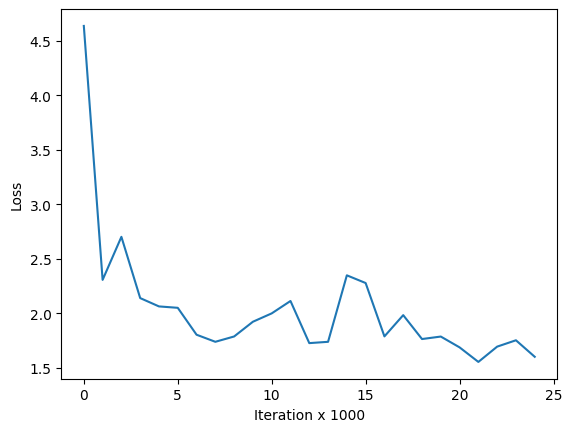

In [28]:
start_time = time.time()

loss_list = []

for iteration in range(NUM_ITER):
    optimizer.zero_grad()
    loss = 0.
    inputs, targets = draw_random_sample(shakespeare_text)
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    for c in range(TEXT_PORTION_SIZE):
        outputs = model(inputs[c].view(1))
        loss += torch.nn.functional.cross_entropy(outputs, targets[c].view(1))
    loss /= TEXT_PORTION_SIZE
    loss.sum().backward()  # Não é necessário especificar retain_graph=True aqui
    optimizer.step()  # Atualize os parâmetros do modelo

    ### LOGGING
    with torch.no_grad():
        if iteration % 200 == 0:
            print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
            print(f'Iteration {iteration} | Loss {loss.item():.2f}\n\n')
            print(evaluate(model, 'Th', 200), '\n')
            print(50*'=')
            
            loss_list.append(loss.item())
            plt.clf()
            plt.plot(range(len(loss_list)), loss_list)
            plt.ylabel('Loss')
            plt.xlabel('Iteration x 1000')
            plt.savefig('loss2.pdf')
            
plt.clf()
plt.ylabel('Loss')
plt.xlabel('Iteration x 1000')
plt.plot(range(len(loss_list)), loss_list)
plt.show()

In [23]:
model.hidden_cell_state

(tensor([[-5.1895e-03, -7.2393e-02,  1.0114e-01,  1.0255e-01, -2.1394e-01,
           8.4169e-02, -8.2930e-02,  1.8201e-02,  1.4446e-01, -5.2519e-02,
          -4.9425e-02, -2.2372e-01, -1.1006e-02,  6.6838e-02, -1.5635e-01,
           1.2250e-02, -1.1495e-01,  3.6930e-02,  3.8040e-02, -3.5794e-02,
           5.1224e-02, -1.1435e-01,  1.5466e-01, -2.3526e-01, -6.7455e-03,
          -2.5685e-01, -8.0613e-02,  9.2289e-03,  2.0200e-02,  7.6053e-02,
           1.7062e-02,  9.9972e-02,  1.6587e-01, -6.5594e-02,  2.9018e-01,
          -3.8882e-02,  1.3265e-02,  4.9085e-02, -2.7538e-01,  1.5793e-02,
           1.0607e-01, -6.7385e-03, -3.9074e-02, -1.4761e-01,  6.9840e-03,
          -1.5554e-01,  5.8854e-02,  6.8644e-02, -1.7338e-02, -2.3603e-02,
           9.4180e-02, -8.4475e-06,  2.6234e-02, -3.4837e-02, -1.4302e-01,
           6.6541e-02,  4.0340e-03,  5.2496e-02,  2.6013e-02,  2.0275e-01,
           5.2792e-02, -7.3155e-02,  2.1666e-01, -2.9796e-01, -1.8217e-01,
          -6.9850e-02, -7